In [1]:
# import _imports
from typing import (List, Tuple, Dict, Callable, Union)

import pandas as pd
import numpy as np

import get_dataset

import warnings

warnings.filterwarnings("ignore")

# 数据获取

In [3]:
# 数据获取
get_dataset.get_data('all')

数据获取(起始日:2013-01-01,结束日:2022-02-28
开始划分高低端象限...


高低端象限数据获取完毕!
开始划分四象限...


四象限数据获取完毕!
开始获取因子数据...


因子数据获取完毕!
开始获取收盘价数据...


收盘价数据获取完毕!


# 读取数据

In [2]:
dichotomy, quandrant, factors_frame, pricing = get_dataset.load_data()

dichotomy.csv文件读取完毕!
quandrant_df.csv文件读取完毕!
factors_frame.csv文件读取完毕!
pricing.csv文件读取完毕!


# 因子分析

## 高低端因子分析

In [5]:
from analyze_func import get_factor_res
from plotting import plotting_dichotomy_res
from my_scr import (quadrant_dic, dichotomy_dic)


In [6]:
# 获取roe高端/低端,营收高端/低端的数据
res = get_factor_res(dichotomy,
                     factors_frame,
                     pricing,
                     dichotomy_dic,
                     group_num=3)


可以看到低ROE端因子单调性都较好

- ILLIQ_20D:第三组（高分组）收益较好，但IC较低为1.79%(分组中最低,较为异常)；
- RealizedSkewness_240D:第一组(低分组)收益较好,IC为3.05%(分组中最高)；
- VolAvg_20D_240D:第一组(低分组)收益较好,IC为-0.34%(分组中最低,较为异常)；
- VolCV_20D:第一组(低分组)收益较好,IC为-2.63%(分组中最高)；



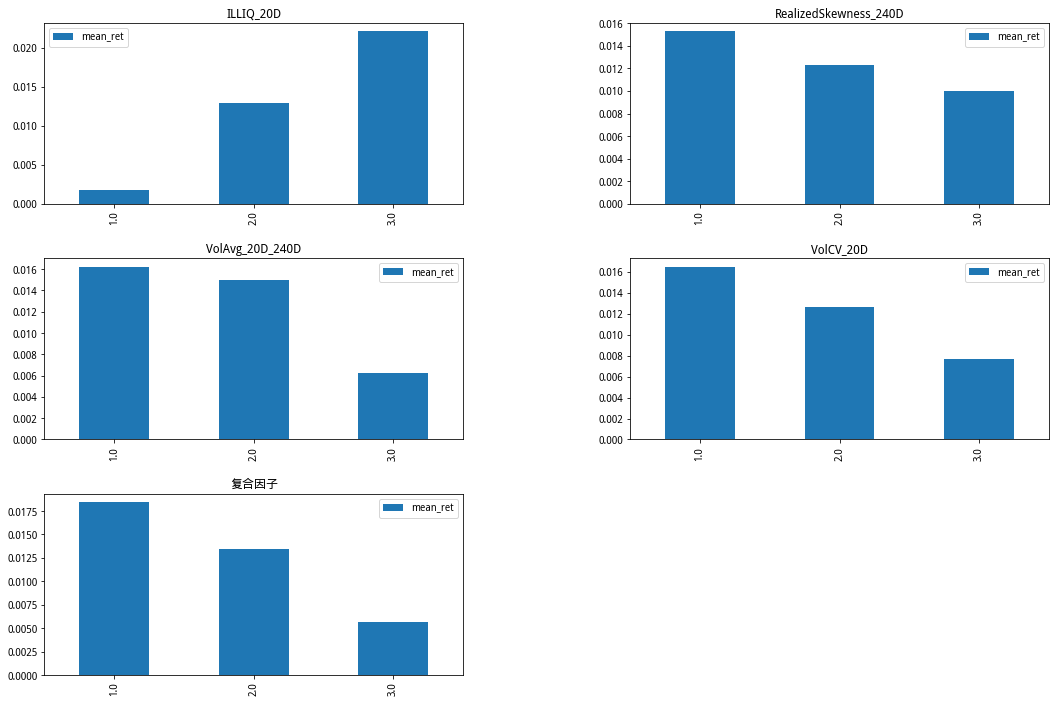

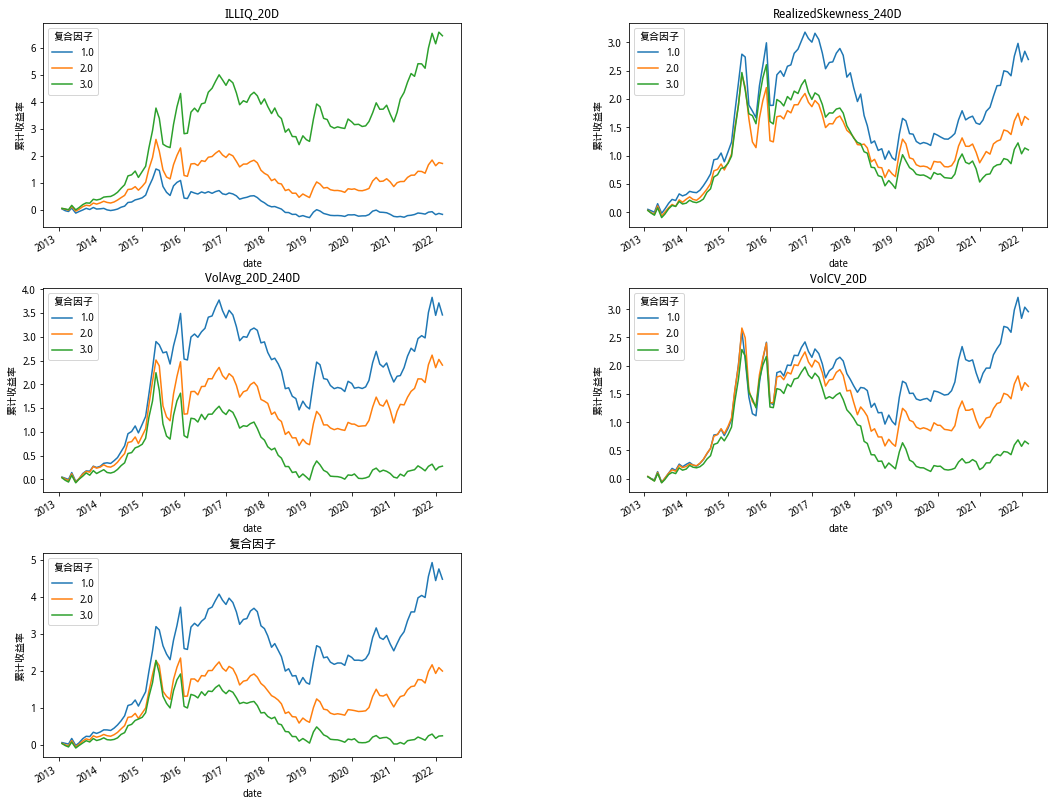

In [7]:
plotting_dichotomy_res(res['低roe端'])

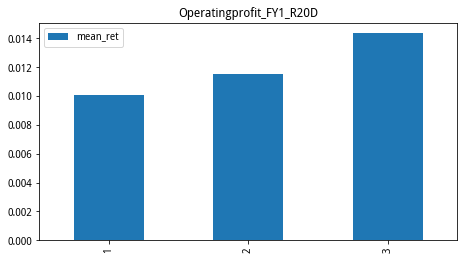

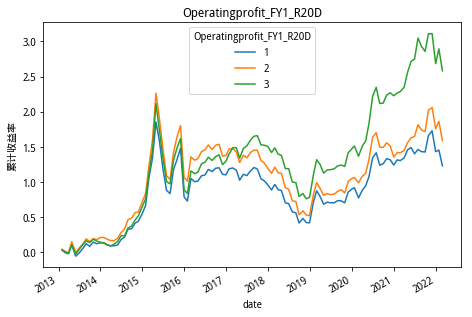

In [8]:
plotting_dichotomy_res(res['高roe端'])

低增长端因子单调性较好
- Gross_profit_margin_chg:第三组收益较高(高分组),IC为-1.27%(分组中最低,较为异常);
- Netprofit_chg:第三组收益较高(高分组),IC为-1.64%(分组绝对值最高);

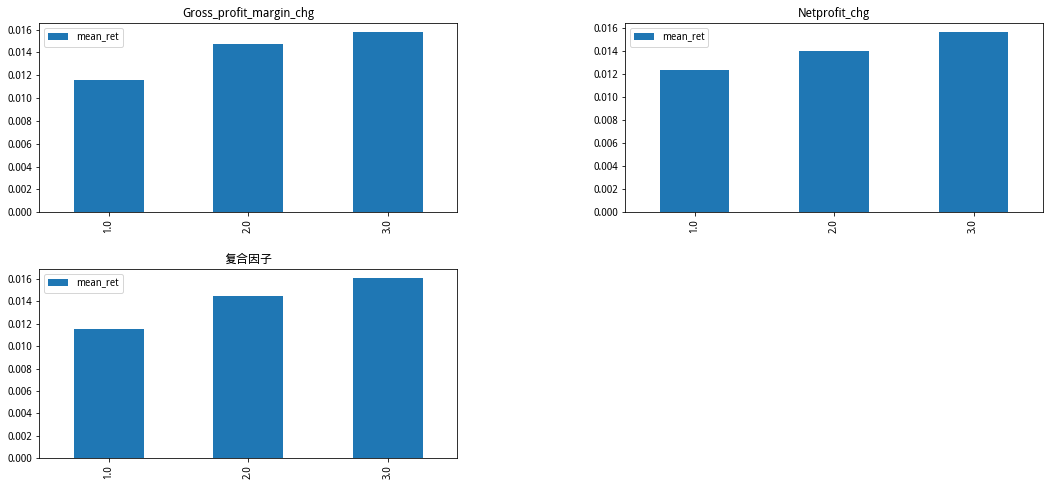

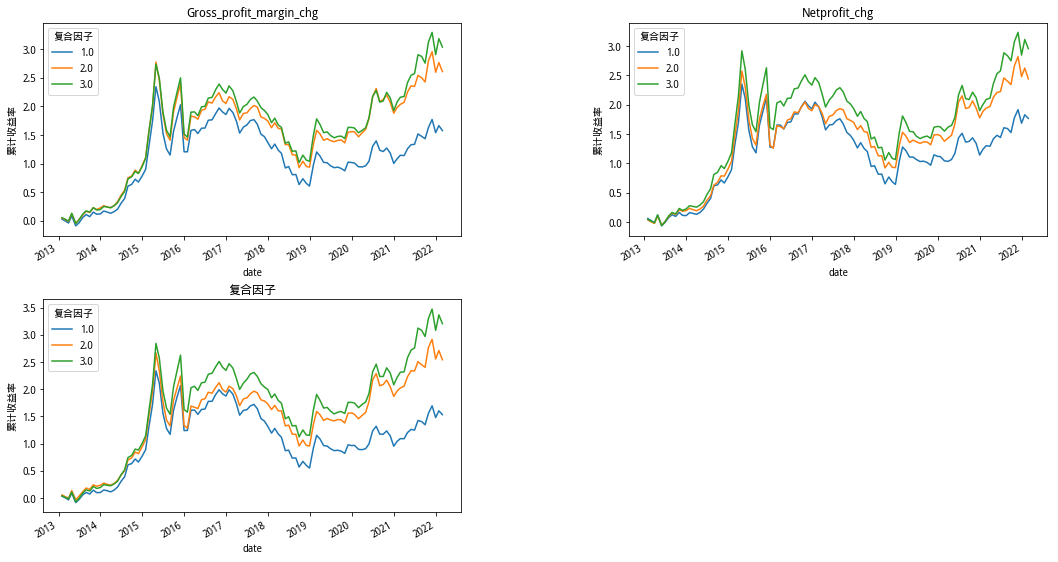

In [9]:
plotting_dichotomy_res(res['低增长端'])

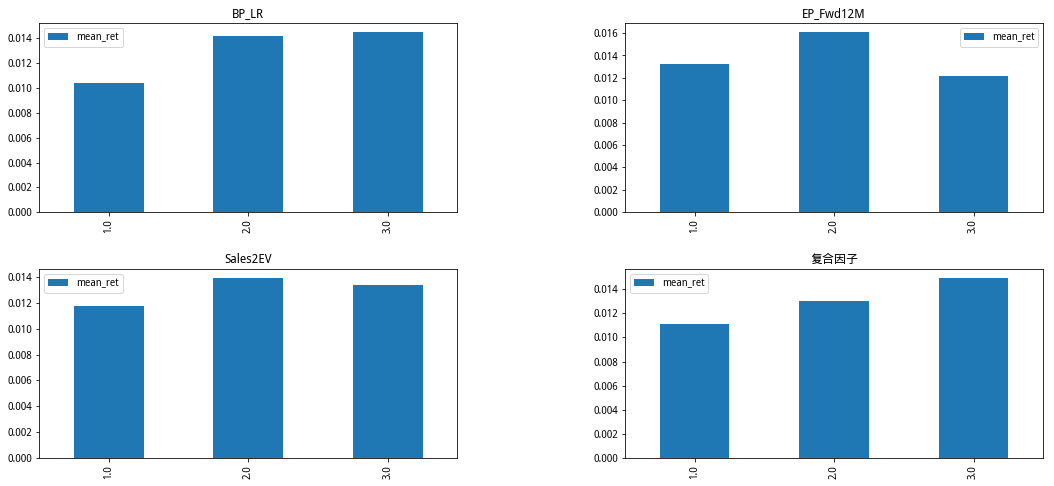

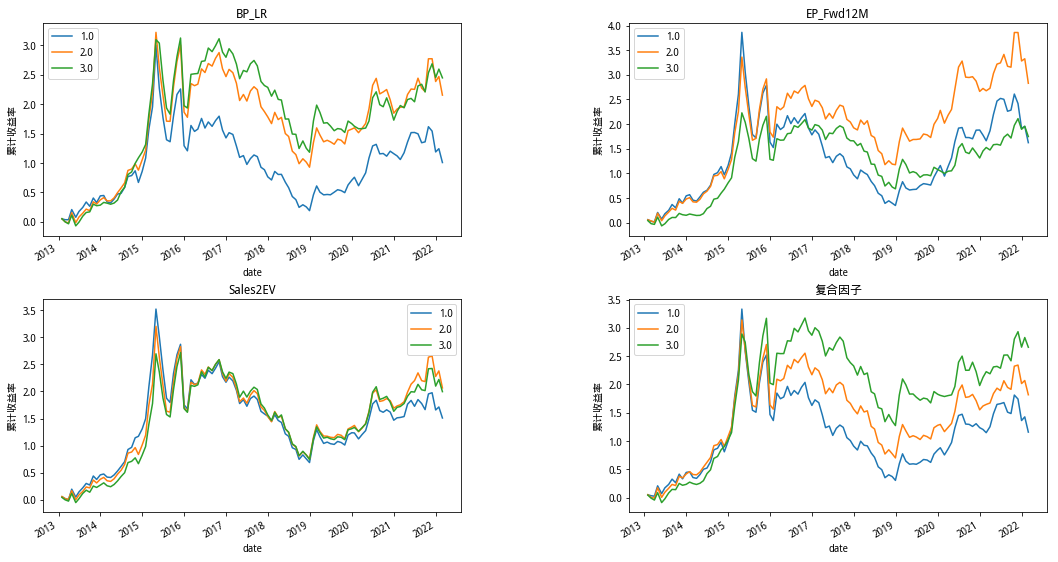

In [10]:
plotting_dichotomy_res(res['高增长端'])

## 四象限因子复合

In [13]:
# 获取roe高端/低端,营收高端/低端的数据

stack_quandrant = quandrant.stack().to_frame('cat_type')
res1 = get_factor_res(stack_quandrant,
                      factors_frame,
                      pricing,
                      quadrant_dic,
                      group_num=3)


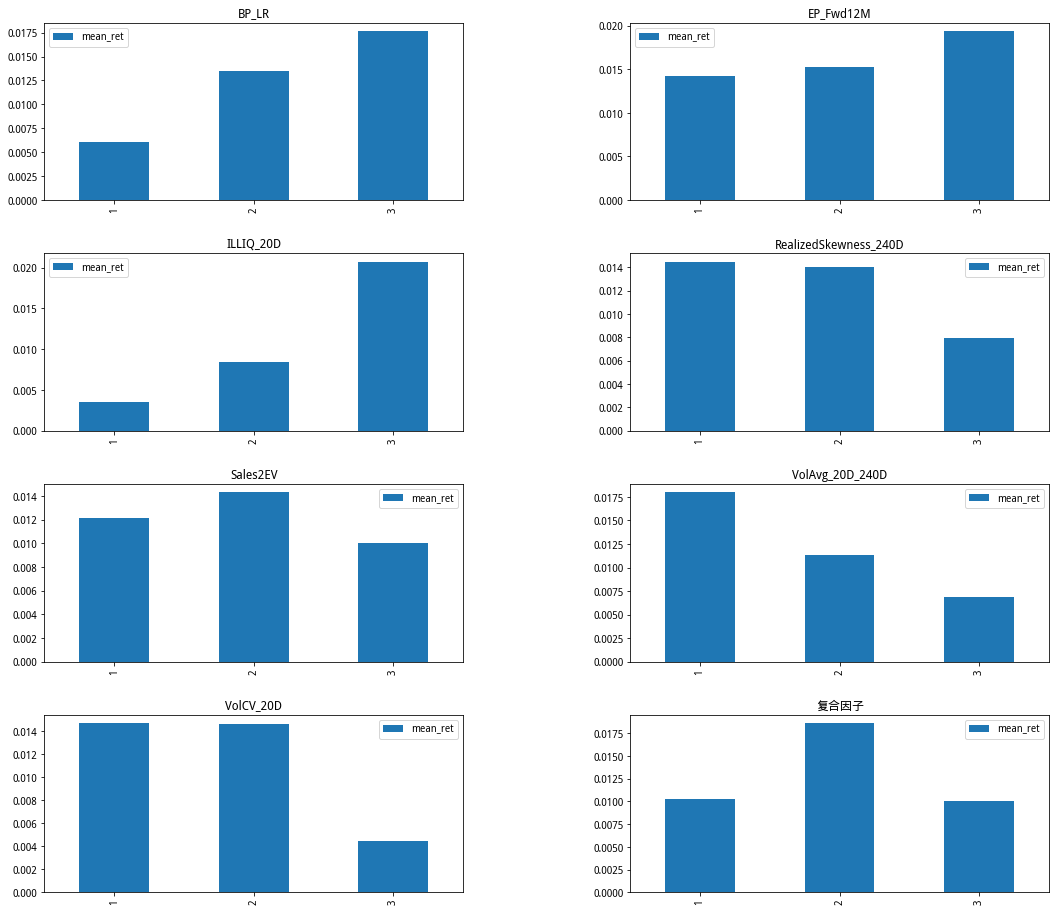

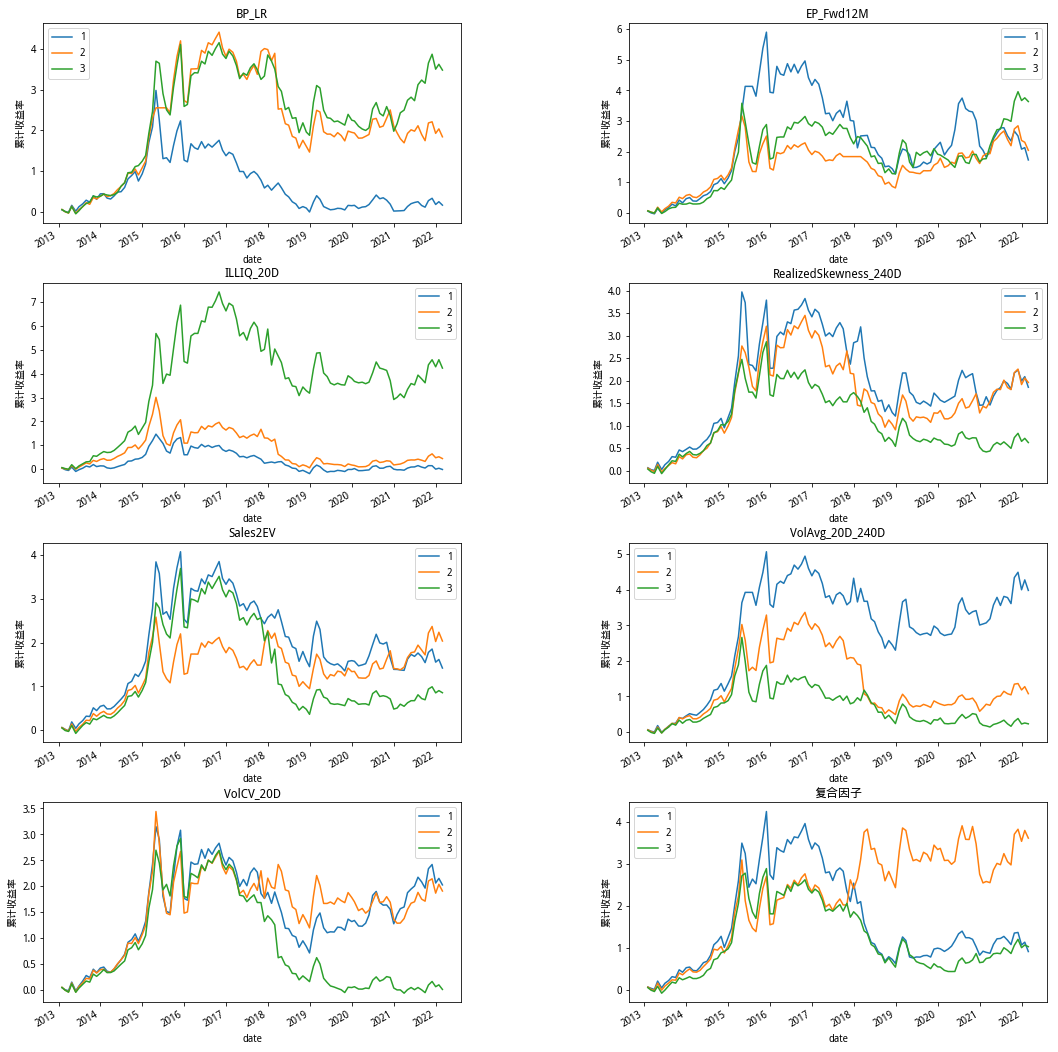

In [14]:
plotting_dichotomy_res(res1['导入期'])

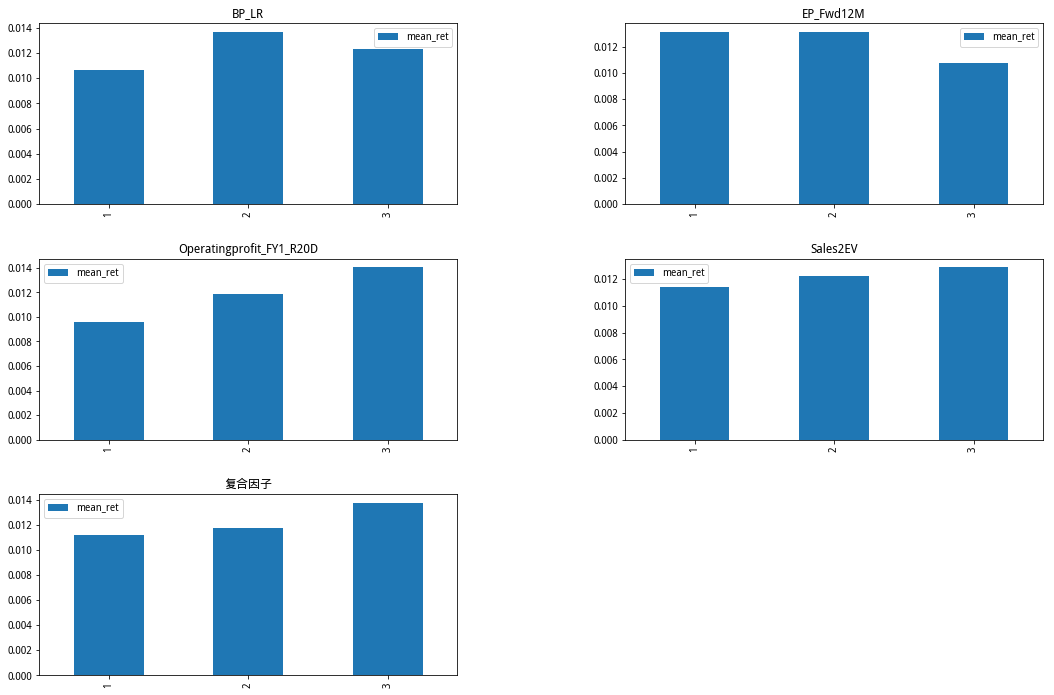

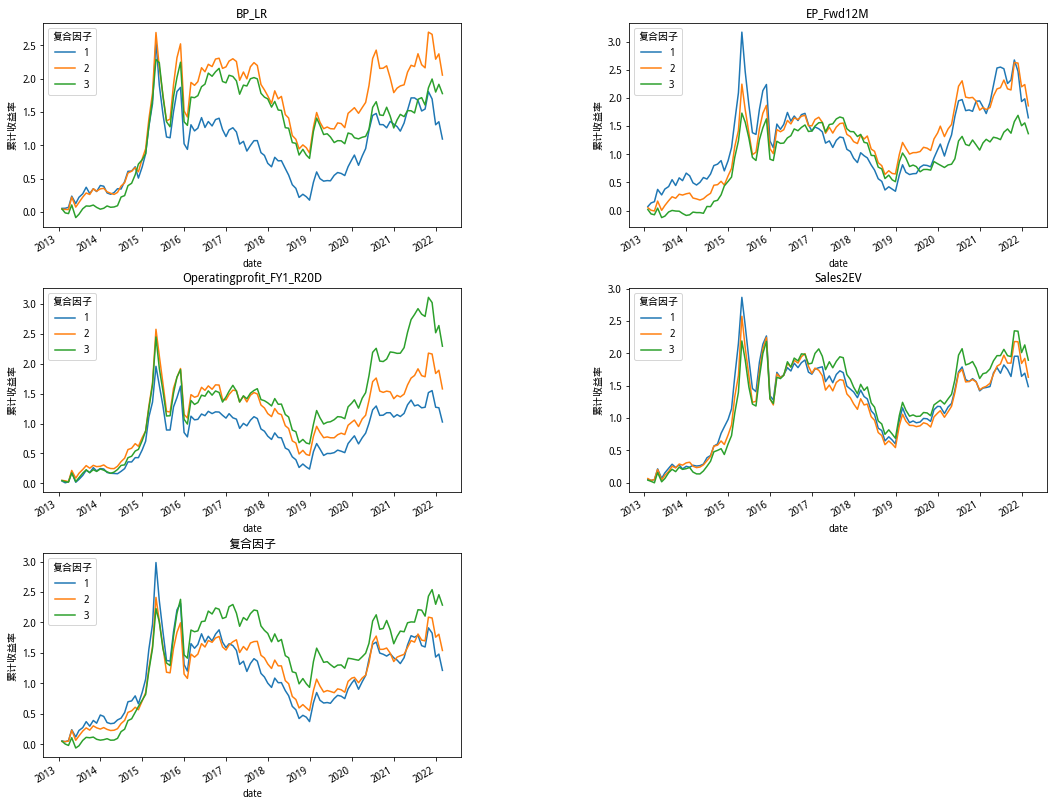

In [15]:
plotting_dichotomy_res(res1['成长期'])

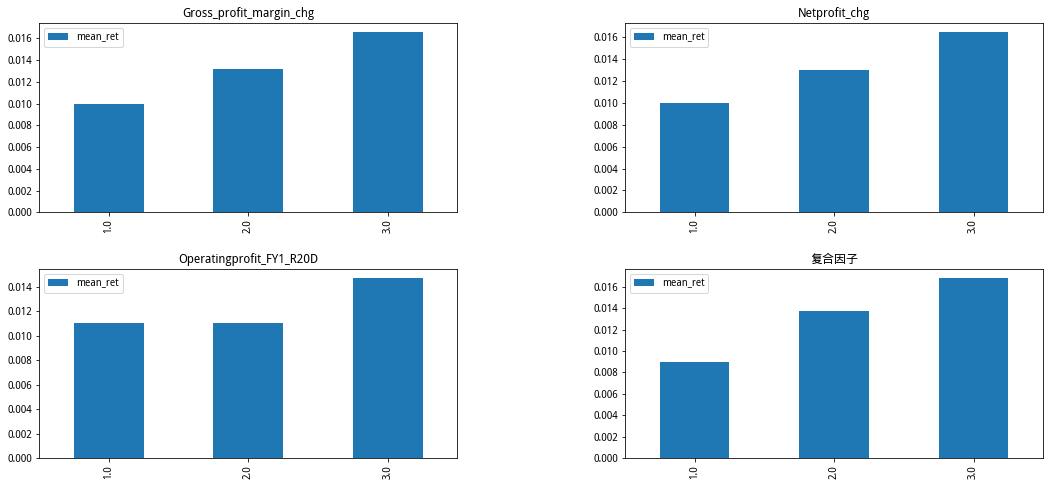

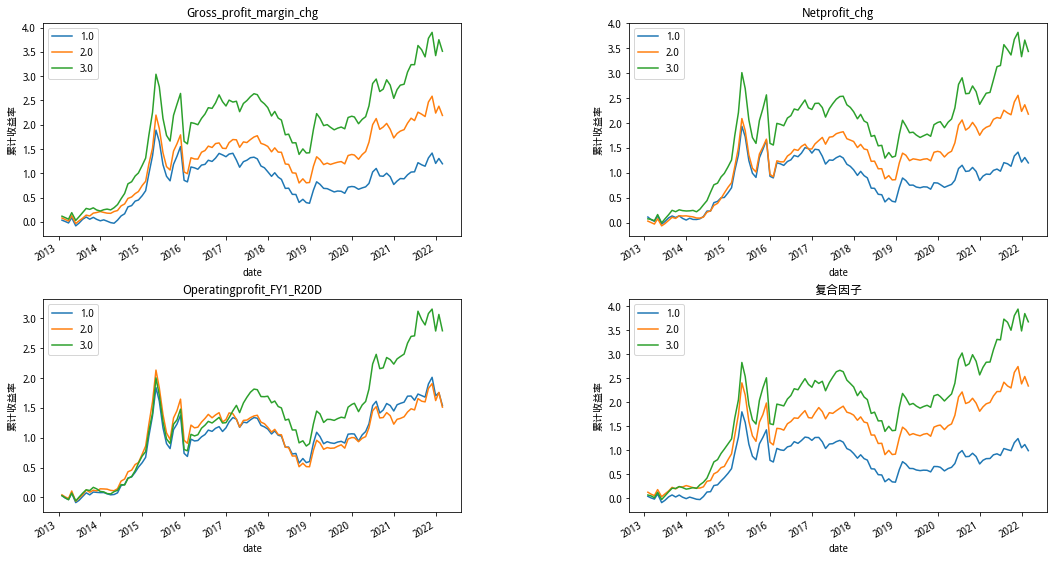

In [16]:
plotting_dichotomy_res(res1['成熟期'])

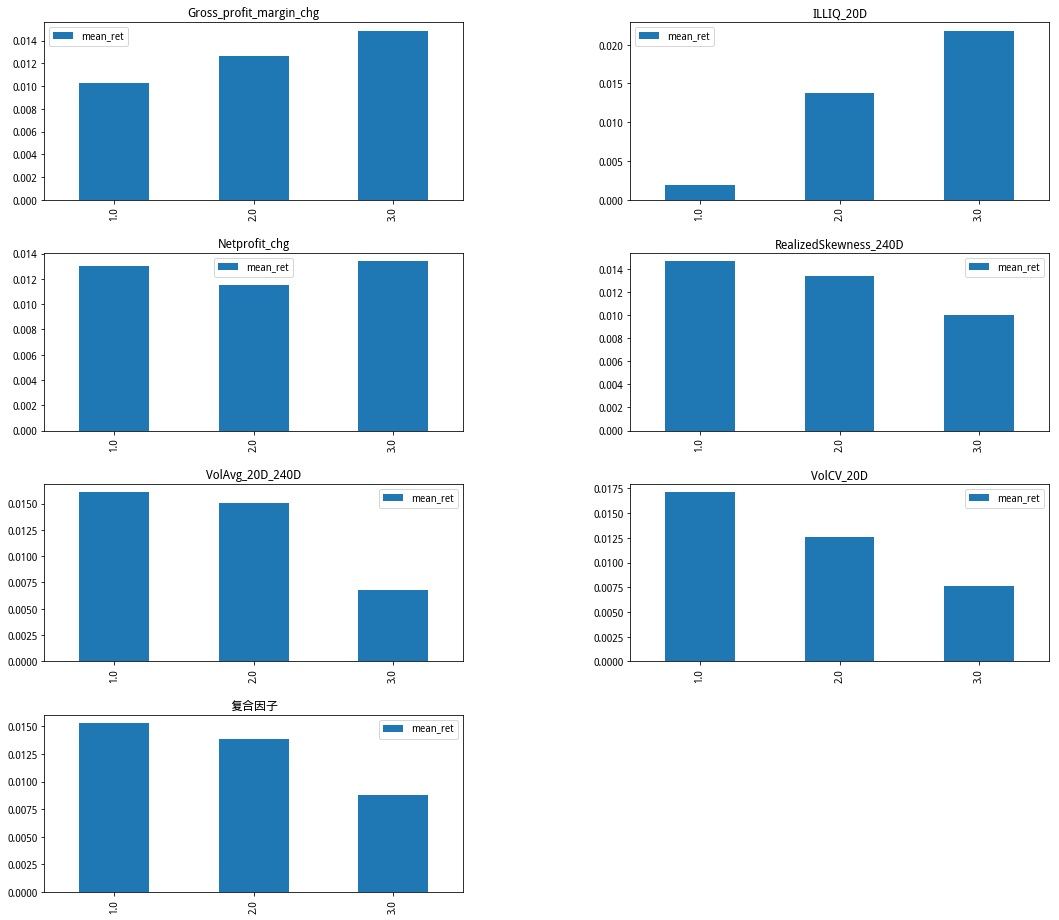

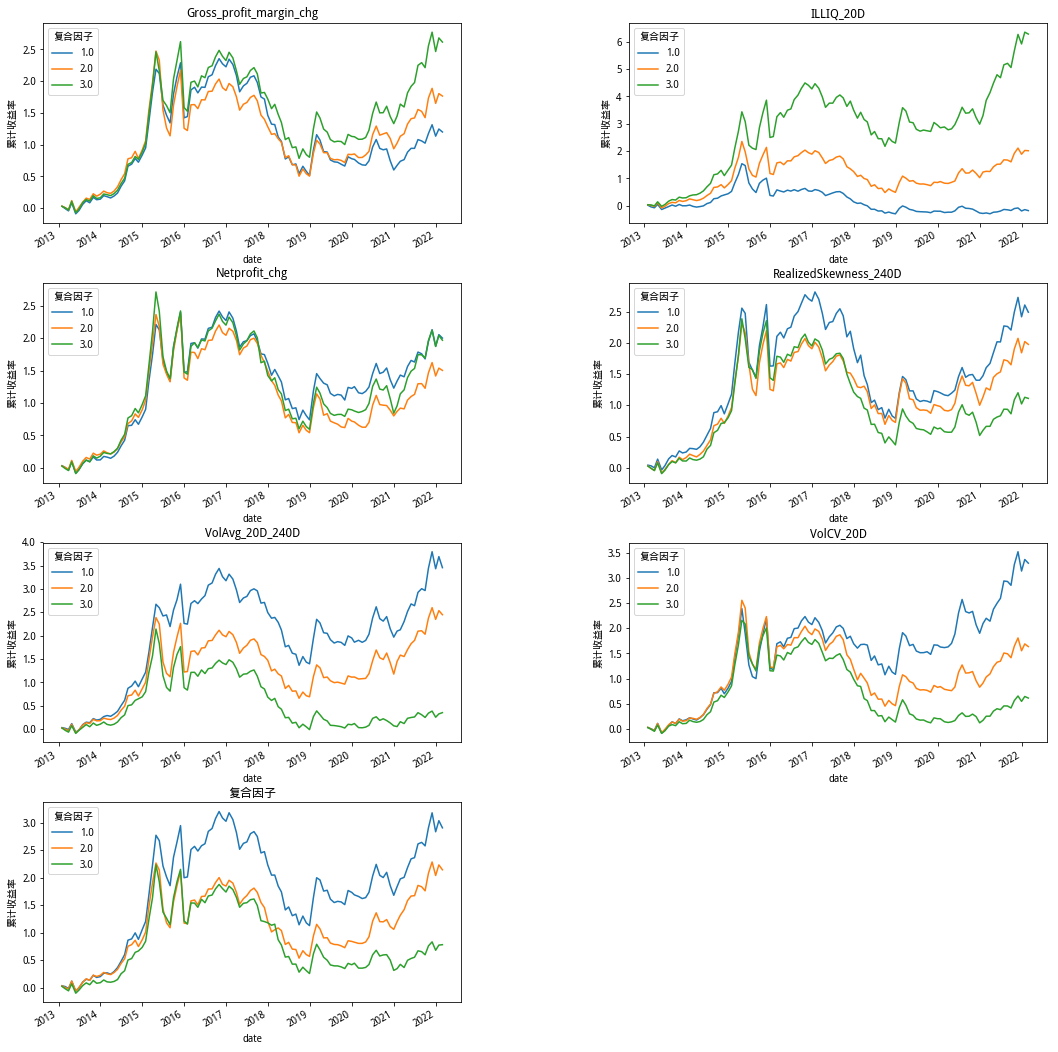

In [17]:
plotting_dichotomy_res(res1['衰退期'])

# 因子复合

In [3]:
import composition_factor as comp_factor
import alphalens as al
import empyrical as ep
from my_scr import get_group_return,add_group

In [4]:
factors = factors_frame.copy()
next_ret = comp_factor.compute_forward_returns(pricing,(1,))
factors['next_ret'] = next_ret[1]

In [5]:
factors_ls = [
    'BP_LR', 'EP_Fwd12M', 'ILLIQ_20D', 'RealizedSkewness_240D', 'Sales2EV',
    'VolAvg_20D_240D', 'VolCV_20D'
]
rank_ls = [
    'ascending', 'ascending', 'ascending', 'descending', 'descending',
    'descending', 'descending'
]

factor_direction = dict(zip(factors_ls, rank_ls))

<AxesSubplot:xlabel='date'>

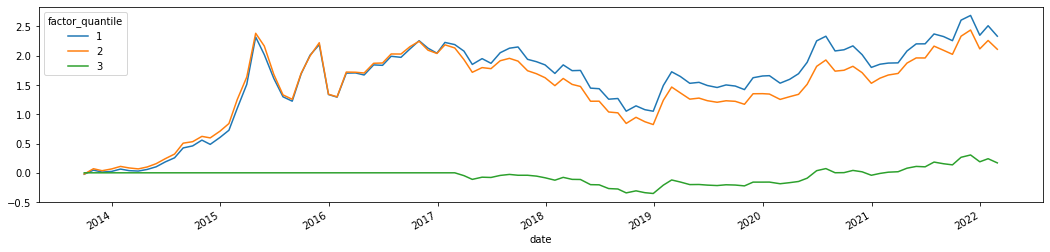

In [29]:
# 全样本
# 按观察结果排序后合成
score = comp_factor.factor_score_indicators(factors,'maxicir_ledoit',factor_direction,5)
group_df = add_group(score,'score',3)
score['factor_quantile'] = group_df['score']

group_ret = get_group_return(score,['factor_quantile']).reset_index(level=0,drop=True)
group_cum = ep.cum_returns(group_ret)

group_cum.plot(figsize=(18,4))

<AxesSubplot:xlabel='date'>

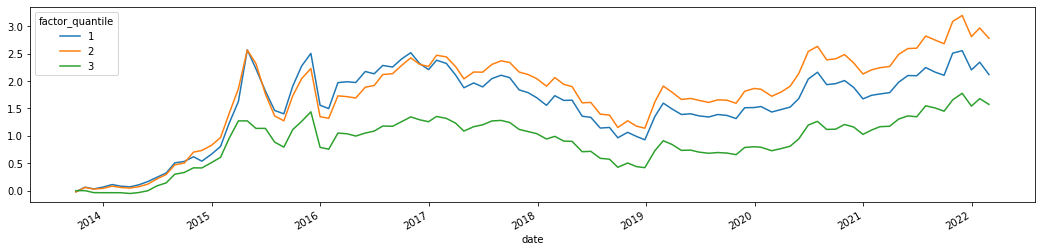

In [30]:
# 全样本
# 直接合成
score1 = comp_factor.fac_maxicir_ledoit(factors,5)
group_df1 = add_group(score1,'score',3)
score1['factor_quantile'] = group_df1['score']
score1['next_ret'] = factors['next_ret']
group_ret1 = get_group_return(score1,['factor_quantile']).reset_index(level=0,drop=True)
group_cum1 = ep.cum_returns(group_ret1)

group_cum1.plot(figsize=(18,4))

<AxesSubplot:xlabel='date'>

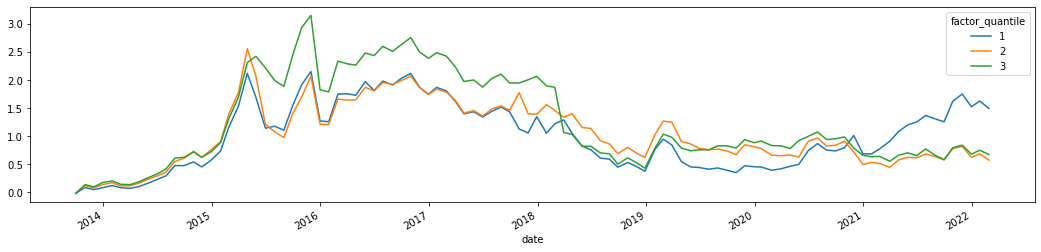

In [31]:
# 导入期
stack_quandrant = quandrant.stack().to_frame('cat_type')

quandrant1 = stack_quandrant.query('cat_type==2').index

quandrant_factor1 = factors.loc[quandrant1].copy()

score = comp_factor.factor_score_indicators(quandrant_factor1,'maxicir_ledoit',factor_direction,5)
group_df = add_group(score,'score',3)
score['factor_quantile'] = group_df['score']

group_ret = get_group_return(score,['factor_quantile']).reset_index(level=0,drop=True)
group_cum = ep.cum_returns(group_ret)

group_cum.plot(figsize=(18,4))

<AxesSubplot:xlabel='date'>

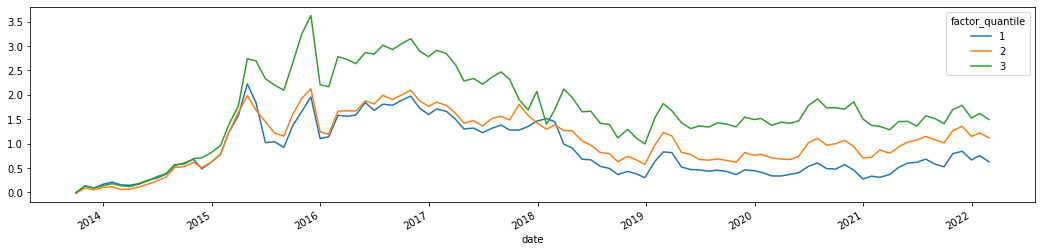

In [32]:
score1 = comp_factor.fac_maxicir_ledoit(quandrant_factor1,5)
group_df1 = add_group(score1,'score',3)
score1['factor_quantile'] = group_df1['score']
score1['next_ret'] = quandrant_factor1['next_ret']
group_ret1 = get_group_return(score1,['factor_quantile']).reset_index(level=0,drop=True)
group_cum1 = ep.cum_returns(group_ret1)

group_cum1.plot(figsize=(18,4))